## Lineaarinen ja polynominen regressio kurpitsan hinnoitteluun - Oppitunti 3

Lataa tarvittavat kirjastot ja datasetti. Muunna data tietokehykseksi, joka sisältää osajoukon datasta:

- Valitse vain kurpitsat, jotka on hinnoiteltu tynnyreittäin
- Muunna päivämäärä kuukaudeksi
- Laske hinta korkeiden ja matalien hintojen keskiarvona
- Muunna hinta vastaamaan tynnyrimääräistä hinnoittelua


In [167]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

pumpkins = pd.read_csv('../../data/US-pumpkins.csv')
pumpkins.head()

City Name Type       Package      Variety Sub Variety  Grade     Date  \
0  BALTIMORE  NaN  24 inch bins          NaN         NaN    NaN  4/29/17   
1  BALTIMORE  NaN  24 inch bins          NaN         NaN    NaN   5/6/17   
2  BALTIMORE  NaN  24 inch bins  HOWDEN TYPE         NaN    NaN  9/24/16   
3  BALTIMORE  NaN  24 inch bins  HOWDEN TYPE         NaN    NaN  9/24/16   
4  BALTIMORE  NaN  24 inch bins  HOWDEN TYPE         NaN    NaN  11/5/16   

   Low Price  High Price  Mostly Low  ...  Unit of Sale Quality Condition  \
0      270.0       280.0       270.0  ...           NaN     NaN       NaN   
1      270.0       280.0       270.0  ...           NaN     NaN       NaN   
2      160.0       160.0       160.0  ...           NaN     NaN       NaN   
3      160.0       160.0       160.0  ...           NaN     NaN       NaN   
4       90.0       100.0        90.0  ...           NaN     NaN       NaN   

  Appearance Storage  Crop Repack  Trans Mode  Unnamed: 24  Unnamed: 25  
0        NaN     NaN   NaN      E         NaN          NaN          NaN  
1        NaN     NaN   NaN      E         NaN          NaN          NaN  
2        NaN     NaN   NaN      N         NaN          NaN          NaN  
3        NaN     NaN   NaN      N         NaN          NaN          NaN  
4        NaN     NaN   NaN      N         NaN          NaN          NaN  

[5 rows x 26 columns]

In [168]:
pumpkins = pumpkins[pumpkins['Package'].str.contains('bushel', case=True, regex=True)]

new_columns = ['Package', 'Variety', 'City Name', 'Month', 'Low Price', 'High Price', 'Date']
pumpkins = pumpkins.drop([c for c in pumpkins.columns if c not in new_columns], axis=1)

price = (pumpkins['Low Price'] + pumpkins['High Price']) / 2

month = pd.DatetimeIndex(pumpkins['Date']).month
day_of_year = pd.to_datetime(pumpkins['Date']).apply(lambda dt: (dt-datetime(dt.year,1,1)).days)

new_pumpkins = pd.DataFrame(
    {'Month': month, 
     'DayOfYear' : day_of_year, 
     'Variety': pumpkins['Variety'], 
     'City': pumpkins['City Name'], 
     'Package': pumpkins['Package'], 
     'Low Price': pumpkins['Low Price'],
     'High Price': pumpkins['High Price'], 
     'Price': price})

new_pumpkins.loc[new_pumpkins['Package'].str.contains('1 1/9'), 'Price'] = price/1.1
new_pumpkins.loc[new_pumpkins['Package'].str.contains('1/2'), 'Price'] = price*2

new_pumpkins.head()


Month  DayOfYear   Variety       City               Package  Low Price  \
70      9        267  PIE TYPE  BALTIMORE  1 1/9 bushel cartons       15.0   
71      9        267  PIE TYPE  BALTIMORE  1 1/9 bushel cartons       18.0   
72     10        274  PIE TYPE  BALTIMORE  1 1/9 bushel cartons       18.0   
73     10        274  PIE TYPE  BALTIMORE  1 1/9 bushel cartons       17.0   
74     10        281  PIE TYPE  BALTIMORE  1 1/9 bushel cartons       15.0   

    High Price      Price  
70        15.0  13.636364  
71        18.0  16.363636  
72        18.0  16.363636  
73        17.0  15.454545  
74        15.0  13.636364

Hajontakaavio muistuttaa meitä siitä, että meillä on kuukausitietoja vain elokuusta joulukuuhun. Tarvitsemme luultavasti enemmän tietoja voidaksemme tehdä johtopäätöksiä lineaarisesti.


<AxesSubplot:xlabel='Month', ylabel='Price'>

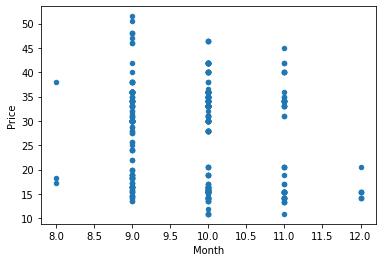

In [169]:
new_pumpkins.plot.scatter('Month','Price')

<AxesSubplot:xlabel='DayOfYear', ylabel='Price'>

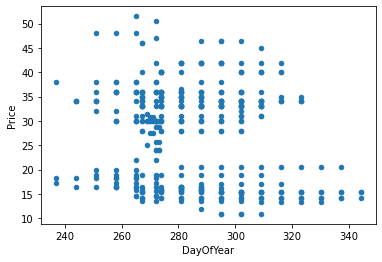

In [170]:
new_pumpkins.plot.scatter('DayOfYear','Price')

In [171]:
print(new_pumpkins['Month'].corr(new_pumpkins['Price']))
print(new_pumpkins['DayOfYear'].corr(new_pumpkins['Price']))

-0.14878293554077535
-0.16673322492745407


Näyttää siltä, että korrelaatio on melko pieni, mutta jokin muu tärkeämpi yhteys on olemassa - koska yllä olevan kuvaajan hintapisteet näyttävät muodostavan useita erillisiä klustereita. Tehdään kuvaaja, joka näyttää eri kurpitsalajikkeet:


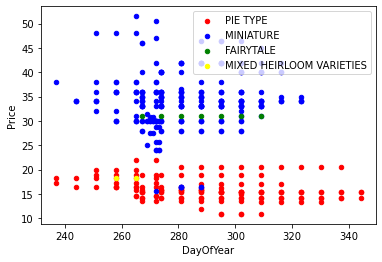

In [172]:
ax=None
colors = ['red','blue','green','yellow']
for i,var in enumerate(new_pumpkins['Variety'].unique()):
    ax = new_pumpkins[new_pumpkins['Variety']==var].plot.scatter('DayOfYear','Price',ax=ax,c=colors[i],label=var)

<AxesSubplot:xlabel='Variety'>

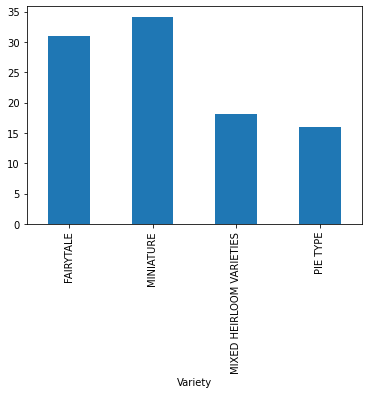

In [173]:
new_pumpkins.groupby('Variety')['Price'].mean().plot(kind='bar')

-0.2669192282197318


<AxesSubplot:xlabel='DayOfYear', ylabel='Price'>

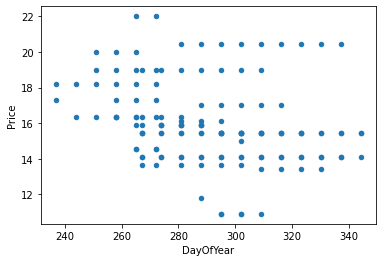

In [174]:
pie_pumpkins = new_pumpkins[new_pumpkins['Variety']=='PIE TYPE']
print(pie_pumpkins['DayOfYear'].corr(pie_pumpkins['Price']))
pie_pumpkins.plot.scatter('DayOfYear','Price')

### Lineaarinen regressio

Käytämme Scikit Learn -kirjastoa lineaarisen regressiomallin kouluttamiseen:


In [175]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

In [176]:
X = pie_pumpkins['DayOfYear'].to_numpy().reshape(-1,1)
y = pie_pumpkins['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train)

pred = lin_reg.predict(X_test)

mse = np.sqrt(mean_squared_error(y_test,pred))
print(f'Mean error: {mse:3.3} ({mse/np.mean(pred)*100:3.3}%)')


Mean error: 2.77 (17.2%)


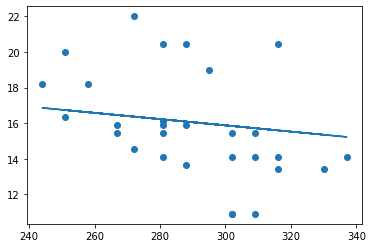

In [177]:
plt.scatter(X_test,y_test)
plt.plot(X_test,pred)

Suoran kulmakerroin voidaan määrittää lineaarisen regressioyhtälön kertoimista:


In [178]:
lin_reg.coef_, lin_reg.intercept_

(array([-0.01751876]), 21.133734359909326)

Voimme käyttää koulutettua mallia hinnan ennustamiseen:


In [179]:
# Pumpkin price on programmer's day

lin_reg.predict([[256]])

array([16.64893156])

### Polynomisregressio

Joskus piirteiden ja tulosten välinen suhde on luonteeltaan epälineaarinen. Esimerkiksi kurpitsan hinnat voivat olla korkeita talvella (kuukaudet=1,2), sitten laskea kesällä (kuukaudet=5-7) ja nousta jälleen. Lineaarinen regressio ei pysty mallintamaan tätä suhdetta tarkasti.

Tässä tapauksessa voimme harkita lisäpiirteiden lisäämistä. Yksinkertainen tapa on käyttää polynomeja syötepiirteistä, mikä johtaa **polynomisregressioon**. Scikit Learnissa voimme automaattisesti esilaskentaa polynomipiirteet käyttämällä putkistoja:


Mean error: 2.73 (17.0%)
Model determination:  0.07639977655280217


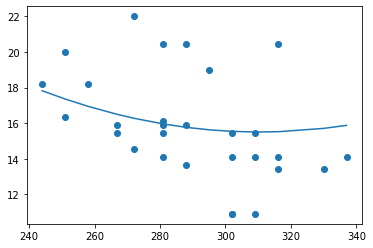

In [180]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(PolynomialFeatures(2), LinearRegression())

pipeline.fit(X_train,y_train)

pred = pipeline.predict(X_test)

mse = np.sqrt(mean_squared_error(y_test,pred))
print(f'Mean error: {mse:3.3} ({mse/np.mean(pred)*100:3.3}%)')

score = pipeline.score(X_train,y_train)
print('Model determination: ', score)

plt.scatter(X_test,y_test)
plt.plot(sorted(X_test),pipeline.predict(sorted(X_test)))

### Koodausvaihtoehdot

Ihanteellisessa maailmassa haluamme pystyä ennustamaan eri kurpitsalajikkeiden hintoja käyttämällä samaa mallia. Jotta voimme ottaa lajikkeen huomioon, meidän täytyy ensin muuntaa se numeeriseen muotoon eli **koodata**. Tähän on useita tapoja:

* Yksinkertainen numeerinen koodaus, joka luo taulukon eri lajikkeista ja korvaa lajikkeen nimen taulukon indeksillä. Tämä ei ole paras idea lineaarista regressiota varten, koska lineaarinen regressio ottaa indeksin numeerisen arvon huomioon, eikä numeerinen arvo todennäköisesti korreloi hinnan kanssa.
* One-hot-koodaus, joka korvaa `Variety`-sarakkeen neljällä eri sarakkeella, yksi kutakin lajiketta varten. Sarakkeessa on arvo 1, jos vastaava rivi kuuluu kyseiseen lajikkeeseen, ja 0 muuten.

Alla oleva koodi näyttää, kuinka voimme suorittaa one-hot-koodauksen lajikkeelle:


In [181]:
pd.get_dummies(new_pumpkins['Variety'])

FAIRYTALE  MINIATURE  MIXED HEIRLOOM VARIETIES  PIE TYPE
70            0          0                         0         1
71            0          0                         0         1
72            0          0                         0         1
73            0          0                         0         1
74            0          0                         0         1
...         ...        ...                       ...       ...
1738          0          1                         0         0
1739          0          1                         0         0
1740          0          1                         0         0
1741          0          1                         0         0
1742          0          1                         0         0

[415 rows x 4 columns]

### Lineaarinen regressio lajikkeella

Käytämme nyt samaa koodia kuin yllä, mutta `DayOfYear`-muuttujan sijaan käytämme yksi-kuumakoodattua lajiketta syötteenä:


In [182]:
X = pd.get_dummies(new_pumpkins['Variety'])
y = new_pumpkins['Price']

In [183]:
def run_linear_regression(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    lin_reg = LinearRegression()
    lin_reg.fit(X_train,y_train)

    pred = lin_reg.predict(X_test)

    mse = np.sqrt(mean_squared_error(y_test,pred))
    print(f'Mean error: {mse:3.3} ({mse/np.mean(pred)*100:3.3}%)')

    score = lin_reg.score(X_train,y_train)
    print('Model determination: ', score)

run_linear_regression(X,y)

Mean error: 5.24 (19.7%)
Model determination:  0.774085281105197


Voimme myös kokeilla käyttää muita ominaisuuksia samalla tavalla ja yhdistää niitä numeerisiin ominaisuuksiin, kuten `Month` tai `DayOfYear`:


In [184]:
X = pd.get_dummies(new_pumpkins['Variety']) \
        .join(new_pumpkins['Month']) \
        .join(pd.get_dummies(new_pumpkins['City'])) \
        .join(pd.get_dummies(new_pumpkins['Package']))
y = new_pumpkins['Price']

run_linear_regression(X,y)

Mean error: 2.84 (10.5%)
Model determination:  0.9401096672643048


### Polynomiregressio

Polynomiregressiota voidaan käyttää myös kategoristen ominaisuuksien kanssa, jotka on koodattu one-hot-muotoon. Polynomiregression kouluttamiseen käytettävä koodi olisi periaatteessa sama kuin mitä olemme nähneet aiemmin.


In [185]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(PolynomialFeatures(2), LinearRegression())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

pipeline.fit(X_train,y_train)

pred = pipeline.predict(X_test)

mse = np.sqrt(mean_squared_error(y_test,pred))
print(f'Mean error: {mse:3.3} ({mse/np.mean(pred)*100:3.3}%)')

score = pipeline.score(X_train,y_train)
print('Model determination: ', score)

Mean error: 2.23 (8.25%)
Model determination:  0.9652870784724543



---

**Vastuuvapauslauseke**:  
Tämä asiakirja on käännetty käyttämällä tekoälypohjaista käännöspalvelua [Co-op Translator](https://github.com/Azure/co-op-translator). Vaikka pyrimme tarkkuuteen, huomioithan, että automaattiset käännökset voivat sisältää virheitä tai epätarkkuuksia. Alkuperäistä asiakirjaa sen alkuperäisellä kielellä tulee pitää ensisijaisena lähteenä. Kriittisen tiedon osalta suositellaan ammattimaista ihmiskääntämistä. Emme ole vastuussa tämän käännöksen käytöstä aiheutuvista väärinkäsityksistä tai virhetulkinnoista.
